In [64]:
import numpy as np
import pandas as pd
import statistics as stat

import plotly.plotly as py
import plotly.figure_factory as ff

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

sns.set()
%matplotlib inline

In [2]:
dfs_orig_results = pd.read_csv(
    './../../data_source/to_analysis/original_images/dfs_original_images.csv', index_col=0
)
dfs_rs_results = pd.read_csv(
    './../../data_source/to_analysis/removed_broken_slices/dfs_removed_broken_slices.csv', index_col=0
)
clinical = pd.read_excel('./../../data_source/clinical/clinical_params.xlsx', index_col=0)

In [3]:
clinical = clinical.loc[dfs_orig_results.index, :]
clinical.shape

(198, 13)

In [4]:
list(clinical.columns)

['Alder',
 'Kjønn',
 'ICD10 kort',
 'T-klassifisering',
 'N-klassifisering',
 'Stadium',
 'Histologi',
 'HPV-status',
 'ECOG',
 'Charlson',
 'Pakkeår',
 'Naxogin dager',
 'Cisplatin']

# Histology Counts

"plt.savefig(\n    './clinical_num_pairplot.png',\n    bbox_inches='tight',\n    transparent=True,\n    dpi=100, \n)"

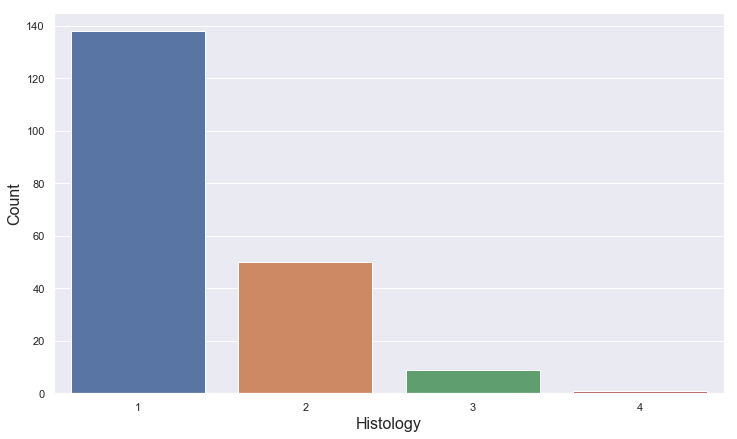

In [5]:
plt.figure(figsize=(12, 7))
sns.countplot(
    x='Histologi',
    data=clinical
)
plt.xticks(np.arange(4), np.arange(4) + 1)
plt.xlabel('Histology', fontsize=16)
plt.ylabel('Count', fontsize=16)
"""plt.savefig(
    './clinical_num_pairplot.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)"""

# Pair Plot Numerical Variables

"plt.savefig(\n    './clinical_num_pairplot.png',\n    bbox_inches='tight',\n    transparent=True,\n    dpi=100, \n)"

<Figure size 1080x1080 with 0 Axes>

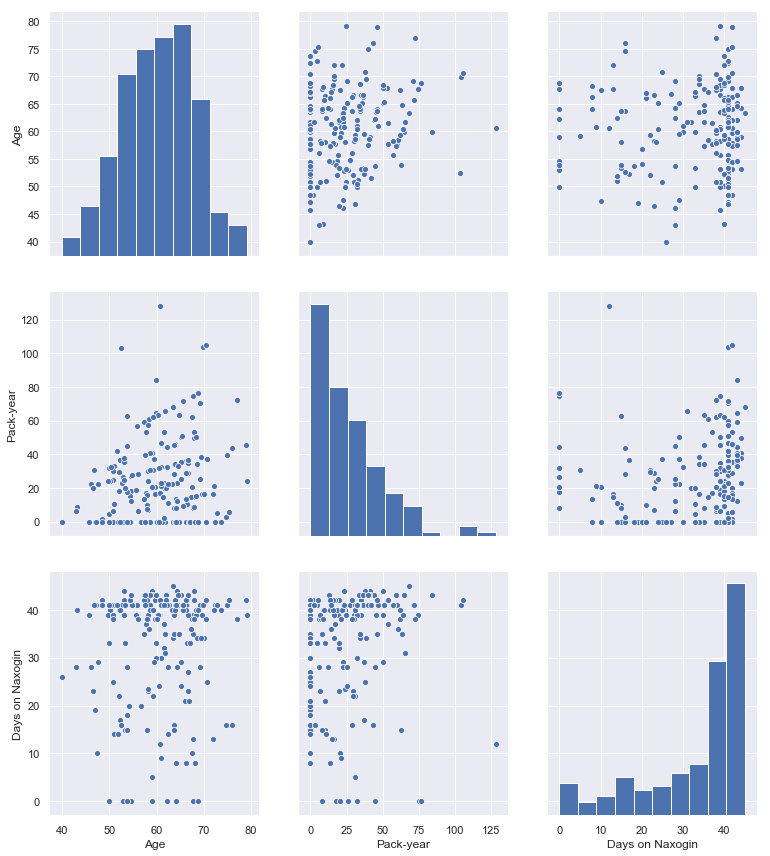

In [6]:
numerical_clinical = ['Alder', 'Pakkeår', 'Naxogin dager']
clin_num = clinical.loc[:, numerical_clinical]
clin_num.columns = ['Age', 'Pack-year', 'Days on Naxogin']

plt.figure(figsize=(15, 15))
sns.pairplot(data=clin_num, height=4, aspect=0.9)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
"""plt.savefig(
    './clinical_num_pairplot.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)"""

"plt.savefig(\n    './clinical_categorical_distr.png',\n    bbox_inches='tight',\n    transparent=True,\n    dpi=100, \n)"

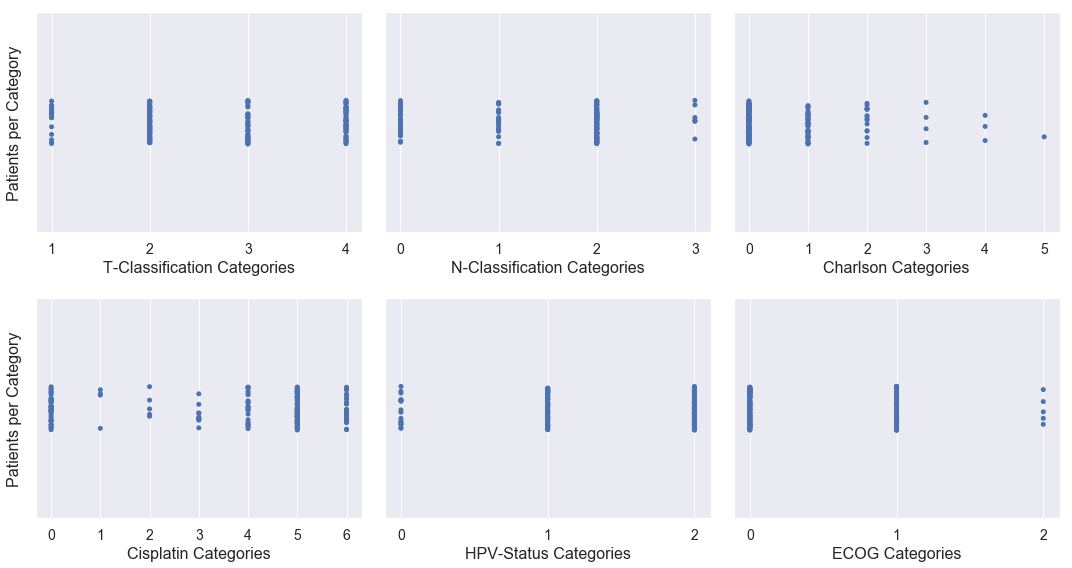

In [9]:
keys = [
    'T-klassifisering', 'N-klassifisering', 'Charlson', 'Cisplatin', 'HPV-status', 'ECOG'
]
labels = [
    'T-Classification', 'N-Classification', 'Charlson', 'Cisplatin', 'HPV-Status', 'ECOG'
]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), sharey=True)
for num, axis in enumerate(axes.ravel()):
    data = clinical.loc[:, keys[num]]
    x_coords = np.unique(data)
    if x_coords[0] == 1:
        data = data - 1
    
    sns.stripplot(x=data, ax=axis)
    axis.set_ylabel('')
    axis.set_xlabel(f'{labels[num]} Categories', fontsize=16)
    axis.set_xticks(np.arange(np.size(x_coords)))
    axis.set_xticklabels(x_coords, fontsize=14)
    
    for patch in axis.patches :
        patch.set_width(0.4)

axes[0, 0].set_ylabel('Patients per Category', fontsize=16)
axes[1, 0].set_ylabel('Patients per Category', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
"""plt.savefig(
    './clinical_categorical_distr.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)"""

# HPV & OPC

In [15]:
opc = pd.read_excel('./../../data_source/clinical/ops.xlsx', index_col=0)
opc = opc.loc[dfs_orig_results.index, :]
opc = np.squeeze(opc.values)

hpv = np.squeeze(clinical.loc[:, 'HPV-status'].values)

In [44]:
hpv_opc = {
    'opc_hpv': 0, 'not_opc_hpv': 0, 'opc_not_hpv': 0, 'not_opc_not_hpv': 0
}
for num, (_hpv, _opc) in enumerate(zip(hpv, opc)):
    if _hpv == 1 and _opc == 1:
        hpv_opc['opc_hpv'] += 1
    elif _hpv == 1 and _opc == 0:
        hpv_opc['not_opc_hpv'] += 1
    elif _hpv == 0 and _opc == 1:
        hpv_opc['opc_not_hpv'] += 1
    else:
        hpv_opc['not_opc_not_hpv'] += 1
        
series_hpv_opc = pd.Series(hpv_opc, index=hpv_opc.keys())

In [66]:
hpv_opc = pd.DataFrame([hpv, opc], index=['HPV', 'OPC'])

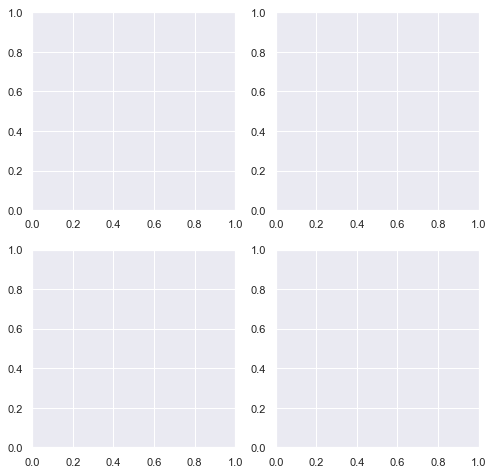

In [78]:
# TODO: Create 2x2 figure as in https://plot.ly/python/facet-plots/
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))


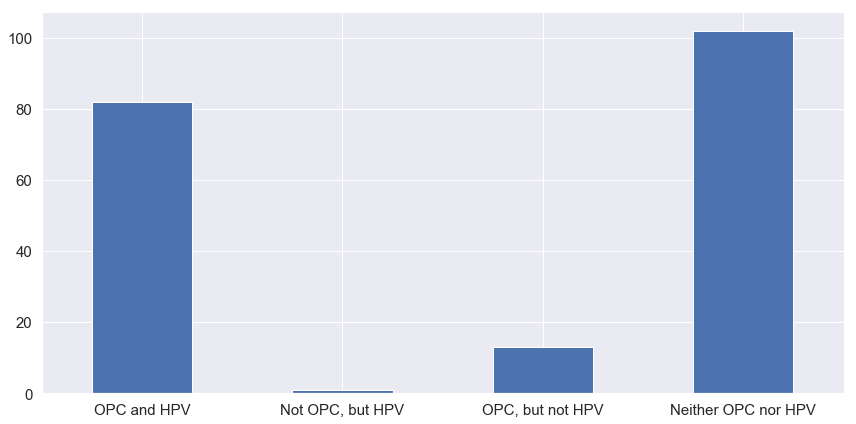

In [59]:
plt.figure(figsize=(12, 6))
series_hpv_opc.plot(kind='bar')
plt.xticks(
    np.arange(4), 
    ['OPC and HPV', 'Not OPC, but HPV', 'OPC, but not HPV', 'Neither OPC nor HPV'], 
    rotation=0,
    fontsize=15
)
plt.yticks(fontsize=15)
plt.tight_layout()
"""
plt.savefig(
    './sex_vs_hpv.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)
"""

# HPV vs Sex

In [ ]:
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.5)
sns.violinplot(x='Kjønn', y='HPV-status', data=clinical)
plt.xticks([0, 1], ['Males', 'Females'])
plt.yticks([0, 1, 2], [0, 1, 2])
plt.xlabel('')
plt.ylabel('HPV Status')
plt.tight_layout()
plt.savefig(
    './sex_vs_hpv.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)

In [ ]:
sum(clinical.loc[:, 'HPV-status'] == 0), sum(clinical.loc[:, 'HPV-status'] == 1), sum(clinical.loc[:, 'HPV-status'] == 2)

# Patient Outcome Distributions

In [ ]:
v1 = np.squeeze(dfs_orig_results.values)
v2 = np.squeeze(dfs_rs_results.values)

fig, axes = plt.subplots(figsize=(15, 8), ncols=2, sharey=True)
sns.countplot(x=v1, saturation=0.85, ax=axes[0])
sns.countplot(x=v2, saturation=0.85, ax=axes[1])

dfs_ratios = [
    [1 - sum(v1) / v1.size, sum(v1) / v1.size],
    [1 - sum(v2) / v2.size, sum(v2) / v2.size]
]
titles = ['Original Dataset', 'Reduced Dataset']
for dnum, axis in enumerate(axes.ravel()):
    axis.set_xticklabels(['Progression-Free Survival', 'Other Event'], fontsize=16)
    axis.set_title(titles[dnum])
    for num, patch in enumerate(axis.patches):
        axis.annotate(
            '{:.1f}%'.format(dfs_ratios[dnum][num] * 100),
            (patch.get_x() + patch.get_width() / 2.5, patch.get_height() + 1), 
            color='k', fontsize=14
        ) 
        #patch.set_width(0.6)

axes[0].tick_params(axis='y', which='major', labelsize=14)
axes[0].set_ylabel('Count', fontsize=16)
axes[1].set_ylabel('')  
      
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)

"""plt.savefig(
    './pfs_distr.png', 
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)"""

In [ ]:
print('No information rate', max([1 - sum(v1) / v1.size, sum(v1) / v1.size, ]))
print('No information rate', max([1 - sum(v2) / v2.size, sum(v2) / v2.size, ]))